In [1]:
from ast import literal_eval

import numpy as np
import corner

import matplotlib.pyplot as plt
pltparams = {"axes.grid": False,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(pltparams)

default_corner_kwargs = dict(bins=40, 
                        smooth=True, 
                        label_kwargs=dict(fontsize=16),
                        title_kwargs=dict(fontsize=16), 
                        quantiles=[],
                        levels=[0.68, 0.95],
                        plot_density=False, 
                        plot_datapoints=False, 
                        fill_contours=False,
                        max_n_ticks=4, 
                        min_n_ticks=3,
                        save=False,
                        truth_color="darkorange")

import pandas as pd
from fiesta.plot import corner_plot



## Variable systematic uncertainty

Load the data

In [2]:
with open("./data/param_dict.dat", "r") as f:
    params = f.read()
params = literal_eval(params)


posterior_fiesta = np.load("./outdir_fiesta/results_production.npz")

Make corner plot

In [3]:
var_names = ["inclination_EM", "log10_mej_dyn", "v_ej_dyn", "Ye_dyn", "log10_mej_wind", "v_ej_wind", "Ye_wind", "sys_err"]
posterior_fiesta = pd.DataFrame(posterior_fiesta["chains"].reshape(-1, 8), columns=var_names)

/home/enlil/hkoehn/miniconda3/envs/fiesta/lib/python3.11/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(


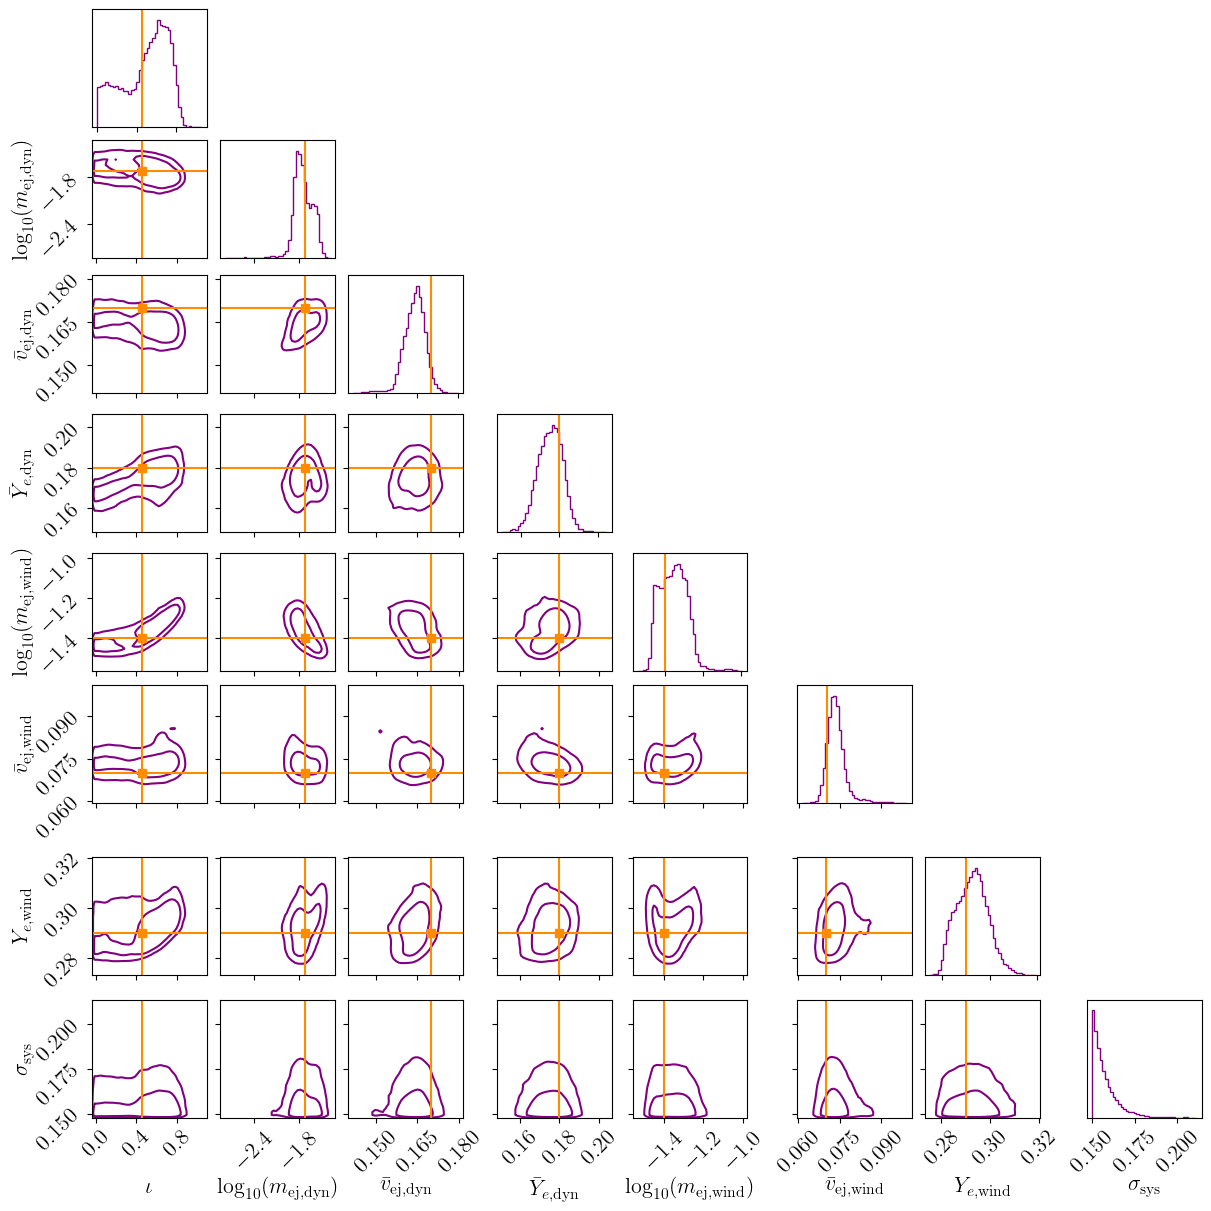

In [4]:
fig, ax = corner_plot(posterior_fiesta, parameter_names=var_names, truths=params, color="purple")


/home/enlil/hkoehn/miniconda3/envs/fiesta/lib/python3.11/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(
/tmp/ipykernel_9372/3065330460.py:13: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.15, left=0.15)


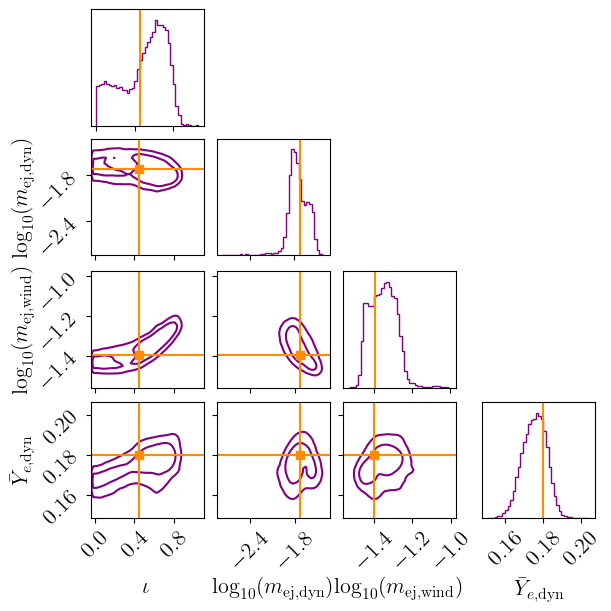

In [6]:
fig, ax = corner_plot(posterior_fiesta, parameter_names=["inclination_EM", "log10_mej_dyn", "log10_mej_wind", "Ye_dyn"], truths=params, color="purple")

handles = []
for c in ["purple"]:
    handle = plt.plot([],[], color=c)[0]
    handles.append(handle)

#for cax in ax.flatten():
#    cax.xaxis.label.set_fontsize(15)
#    cax.yaxis.label.set_fontsize(15)
#    cax.tick_params(labelsize=12)

fig.subplots_adjust(bottom=0.15, left=0.15)
fig.savefig("./figures/injection_Bu2025.pdf", dpi=250, bbox_inches="tight")